# Using Auxillary Data To Reduce Forgetting
In this notebook we will explore how we can use auxillary data to reduce forgetting.

In [17]:
%%capture
!pip install pandas
!pip install tensorboard
!pip install matplotlib

In [18]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# To create csv files from tensorboard logs
def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), "some scalars were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

# Get's the tags from a tensorboard log
def get_scalar_tags(path):
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    return ea.Tags()

# Creates a list of n random colors
def random_colors(n):
    np.random.seed(42)
    colors = []
    for i in range(n):
        colors.append(np.random.rand(3,))
    return colors

def split_string_by_slash(input_string):
    # Use the split() method to split the string by "/"
    substrings = input_string.split("/")
    return substrings

def join_strings_with_slash(substrings):
    # Use the join() method to join the list of substrings with "/"
    joined_string = "/".join(substrings)
    return joined_string

def remove_substring_and_after(input_string, substring):
    # Find the index of the substring in the input string
    index = input_string.find(substring)
    
    # If the substring is found, remove it and everything after it
    if index != -1:
        modified_string = input_string[:index]
    else:
        # If the substring is not found, return the original string
        modified_string = input_string
    
    return modified_string


cols = [
    'b',  # Blue
    'g',  # Green
    'r',  # Red
    'c',  # Cyan
    'm',  # Magenta
    'y',  # Yellow
    'k',  # Black
    '#FFA07A',  # Light Salmon
    '#20B2AA',  # Light Sea Green
    '#800080',  # Purple
]

## In the Batch Scenario
Here we will look at how our models perform in the batch scenario, ie. where all training data is avaliable at the start of training. Let's first plot the training accuracy and loss of our three models (VGG16, ResNet18 and ResNet50) on the CIFAR10 dataset.

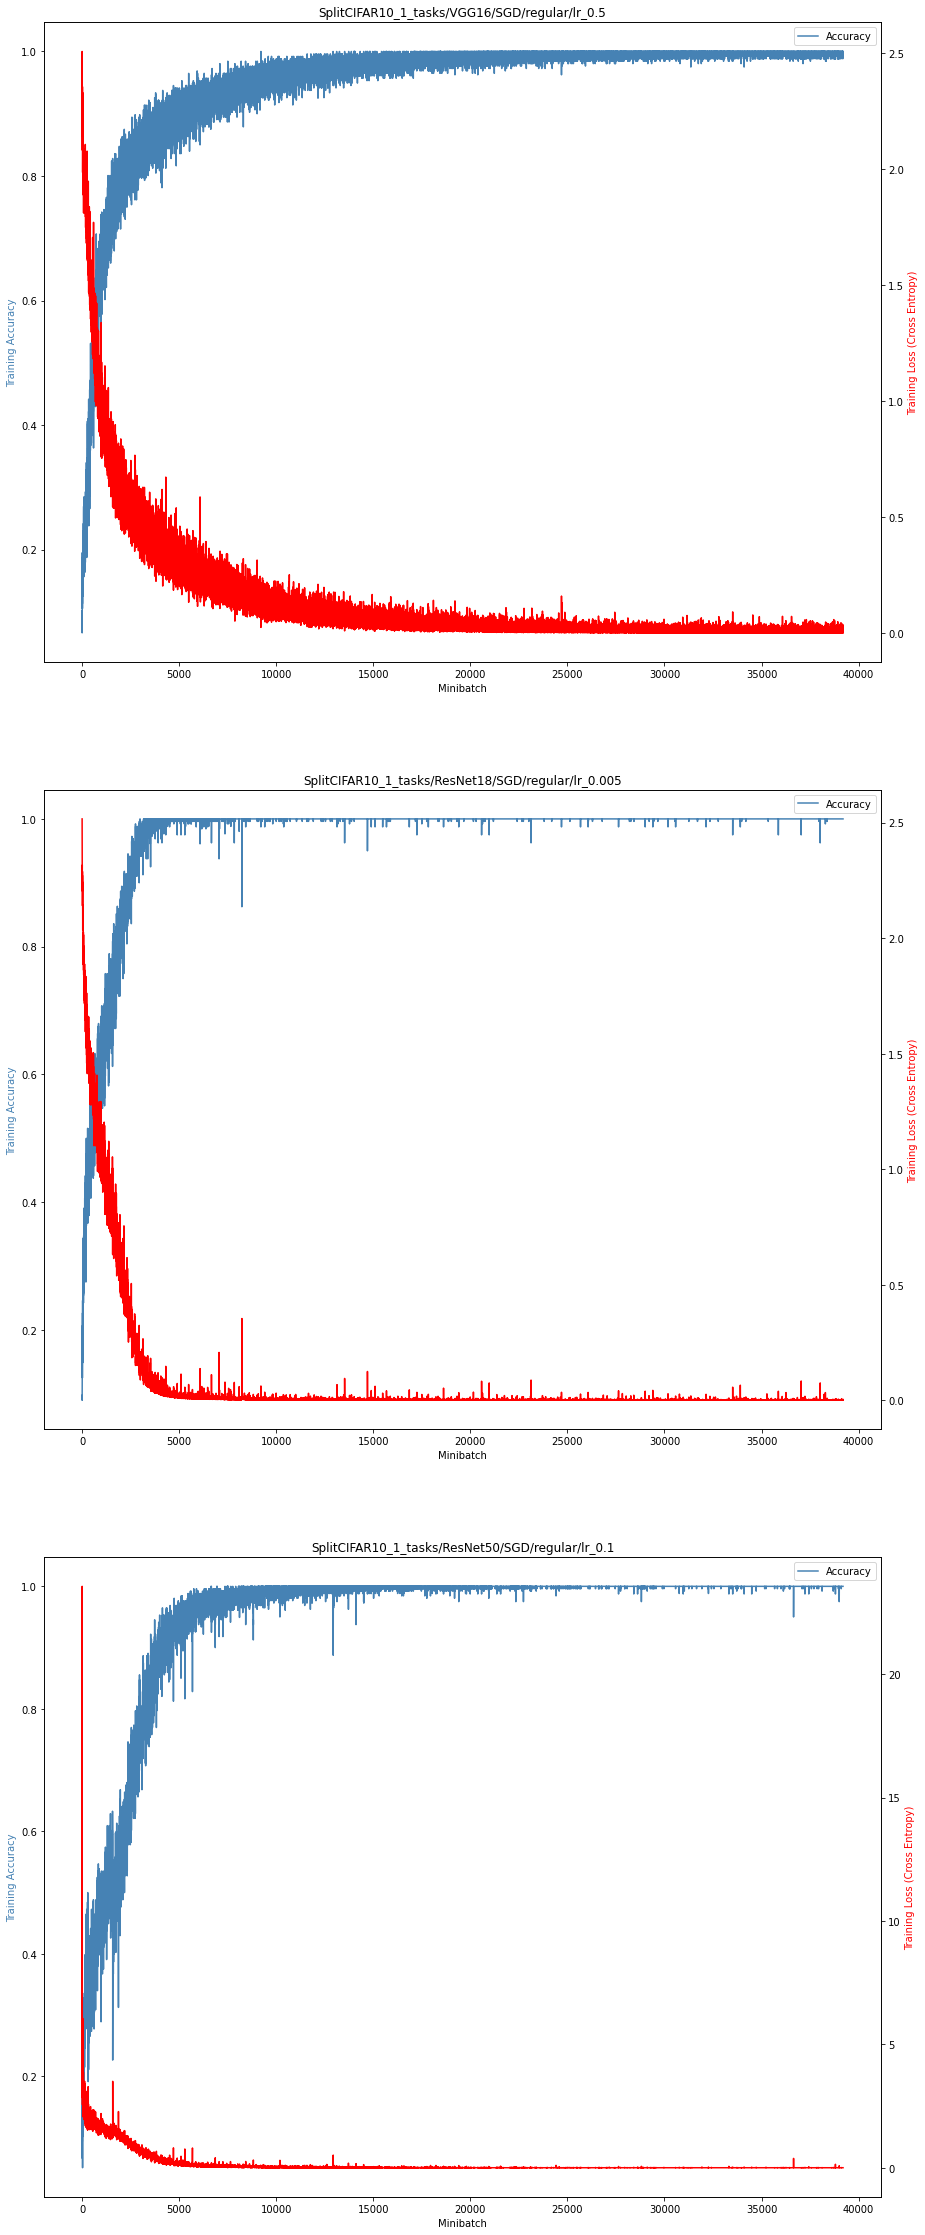

In [19]:
# Let's create a list of all the experiments we want to compare:
experiments = [
    "log/SplitCIFAR10_1_tasks/VGG16/SGD/regular/lr_0.5",
    "log/SplitCIFAR10_1_tasks/ResNet18/SGD/regular/lr_0.005",
    "log/SplitCIFAR10_1_tasks/ResNet50/SGD/regular/lr_0.1"
]

# Let's first get the data from our tensorboard logs:
data = []
for exp in experiments:
    data.append(parse_tensorboard(exp, [
        "Top1_Acc_MB/train_phase/train_stream/Task000", 
        "Loss_MB/train_phase/train_stream/Task000",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/3",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/4",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/5",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/6",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/7",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/8",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/9"
    ]))

# Let's now plot a graph for the accuracy and loss over training for each experiment:
col1 = 'steelblue'
col2 = 'red'
fig, ax = plt.subplots(len(experiments), 1, figsize=(15, 40))
for i, exp in enumerate(experiments):
    ax[i].plot(data[i]["Top1_Acc_MB/train_phase/train_stream/Task000"]["value"], label="Accuracy", color=col1)
    ax2 = ax[i].twinx()
    ax2.plot(data[i]["Loss_MB/train_phase/train_stream/Task000"]["value"], label="Loss", color=col2)
    ax[i].set_title(exp[4:])
    ax[i].set_xlabel("Minibatch")
    ax[i].set_ylabel("Training Accuracy", color=col1)
    ax2.set_ylabel("Training Loss (Cross Entropy)", color=col2)
    ax[i].legend()

Let's now look at the training accuracy for each individual class during training:

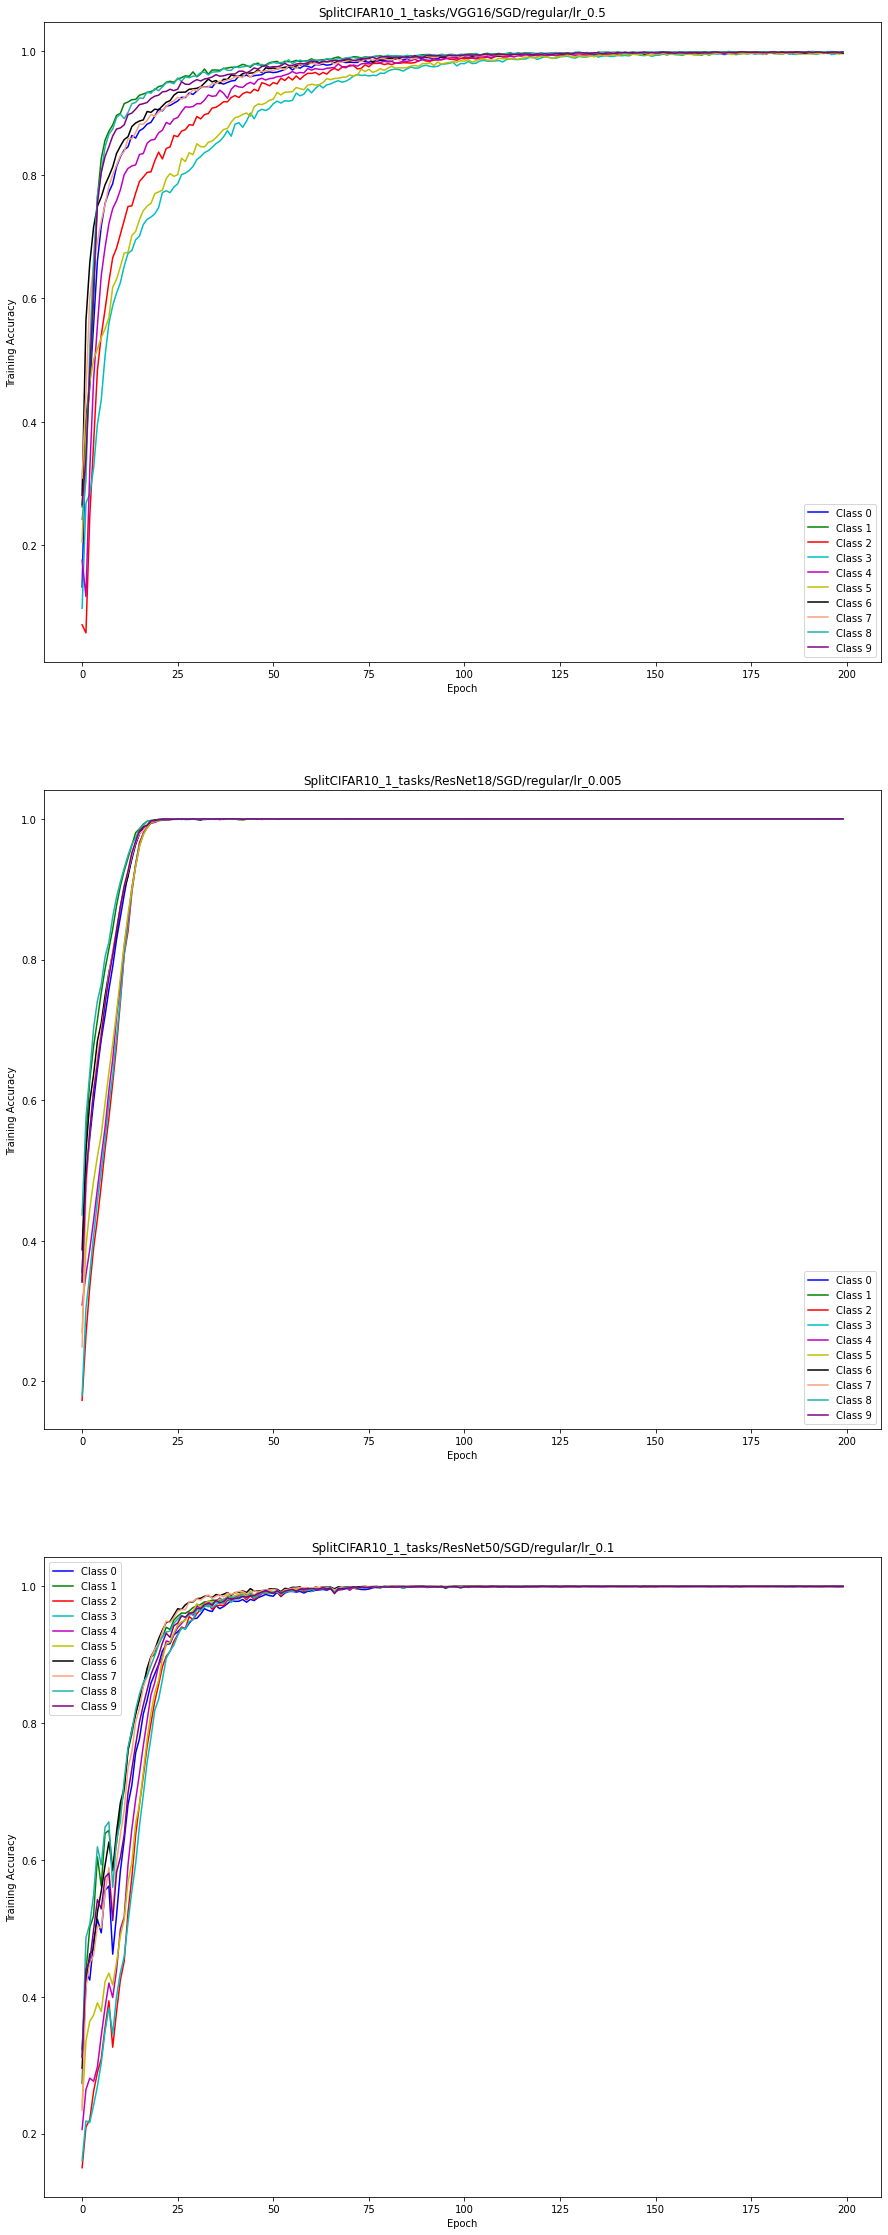

In [20]:
# Let's now plot a graph for the accuracy and loss over training for each experiment:
fig, ax = plt.subplots(len(experiments), 1, figsize=(15, 40))
for i, exp in enumerate(experiments):
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0"]["value"], label="Class 0", color=cols[0])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1"]["value"], label="Class 1", color=cols[1])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2"]["value"], label="Class 2", color=cols[2])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/3"]["value"], label="Class 3", color=cols[3])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/4"]["value"], label="Class 4", color=cols[4])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/5"]["value"], label="Class 5", color=cols[5])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/6"]["value"], label="Class 6", color=cols[6])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/7"]["value"], label="Class 7", color=cols[7])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/8"]["value"], label="Class 8", color=cols[8])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/9"]["value"], label="Class 9", color=cols[9])
    ax[i].set_title(exp[4:])
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Training Accuracy")
    ax[i].legend()

Let's now look at the test accuracy: TODO

## In the Task Incremental Scenario
Here we will look at how our models perform in the task incremental scenario, where we train on one task at a time where each task is made up of a number of classes. Here we use CIFAR10 split into 5 tasks where each task is made up of 2 classes. Let's first look at how training went:

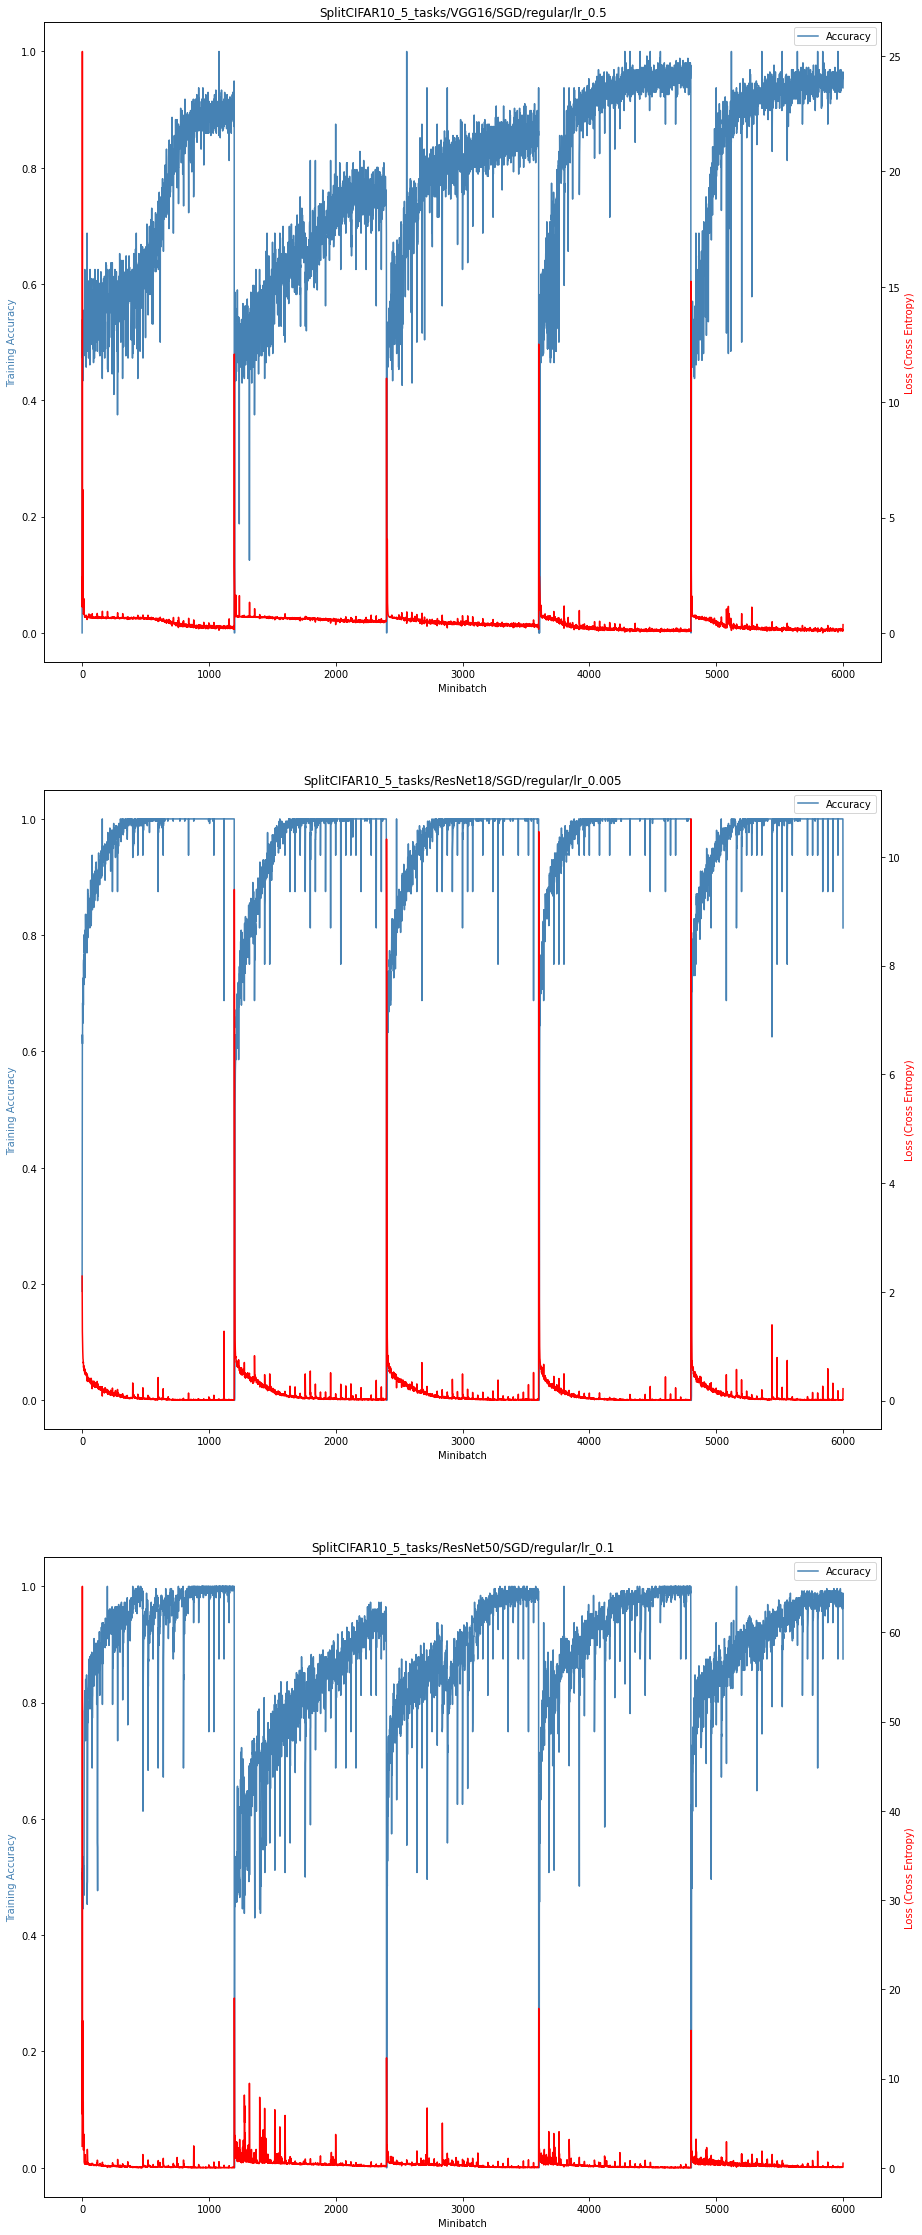

In [21]:
# Let's create a list of all the experiments we want to compare:
experiments = [
    "log/SplitCIFAR10_5_tasks/VGG16/SGD/regular/lr_0.5",
    "log/SplitCIFAR10_5_tasks/ResNet18/SGD/regular/lr_0.005",
    "log/SplitCIFAR10_5_tasks/ResNet50/SGD/regular/lr_0.1"
]


# Let's first get the data from our tensorboard logs:
data = []
for exp in experiments:
    data.append(parse_tensorboard(exp, [
        "Top1_Acc_MB/train_phase/train_stream/Task000", 
        "Loss_MB/train_phase/train_stream/Task000",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/3",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/4",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/5",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/6",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/7",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/8",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/9"
    ]))

# Let's now plot a graph for the accuracy and loss over training for each experiment:
col1 = 'steelblue'
col2 = 'red'
fig, ax = plt.subplots(len(experiments), 1, figsize=(15, 40))
for i, exp in enumerate(experiments):
    ax[i].plot(data[i]["Top1_Acc_MB/train_phase/train_stream/Task000"]["value"], label="Accuracy", color=col1)
    ax2 = ax[i].twinx()
    ax2.plot(data[i]["Loss_MB/train_phase/train_stream/Task000"]["value"], label="Loss", color=col2)
    ax[i].set_title(exp[4:])
    ax[i].set_xlabel("Minibatch")
    ax[i].set_ylabel("Training Accuracy", color=col1)
    ax2.set_ylabel("Loss (Cross Entropy)", color=col2)
    ax[i].legend()


Training appears to be going well with the model achieving a high accuracy on training data and a low loss on each task by the end of training on it. At the begining of each task we see a large sharp increase in loss and large decrease in accuracy, which is what we would expect as the new data is very different.

Let's now look at the accuracies for each individual class to assess the degree of forgetting:

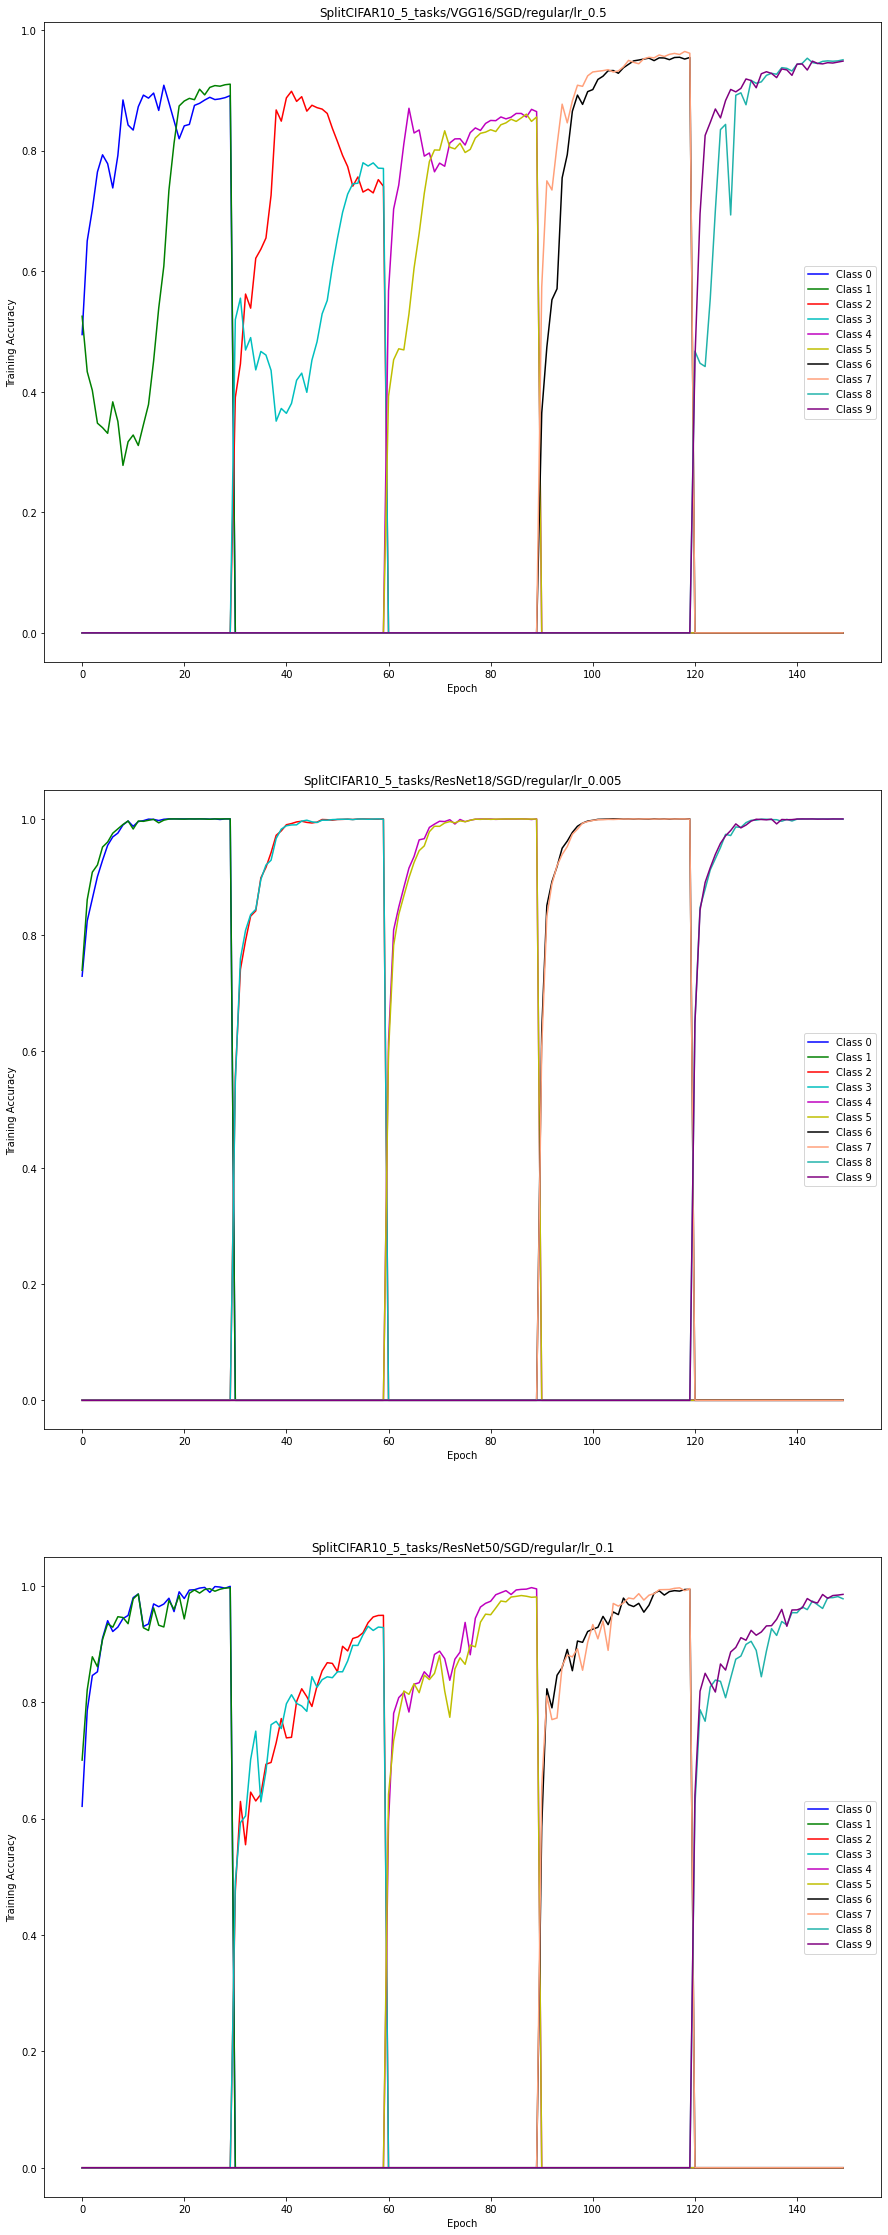

In [22]:
# Let's now plot a graph for the accuracy and loss over training for each experiment:
fig, ax = plt.subplots(len(experiments), 1, figsize=(15, 40))
for i, exp in enumerate(experiments):
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0"]["value"], label="Class 0", color=cols[0])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1"]["value"], label="Class 1", color=cols[1])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2"]["value"], label="Class 2", color=cols[2])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/3"]["value"], label="Class 3", color=cols[3])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/4"]["value"], label="Class 4", color=cols[4])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/5"]["value"], label="Class 5", color=cols[5])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/6"]["value"], label="Class 6", color=cols[6])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/7"]["value"], label="Class 7", color=cols[7])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/8"]["value"], label="Class 8", color=cols[8])
    ax[i].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/9"]["value"], label="Class 9", color=cols[9])
    ax[i].set_title(exp[4:])
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Training Accuracy")
    ax[i].legend()

We can see in the plots that forgetting is unanimous across models and is severe. This is to be expected as the model is not being trained on previous tasks and so will forget them in order to optimize on whatever it is currently beign trained on (the current task). Let's lastly look at the test accuracy: TODO

## Using a labelled stratified subset of the data
In these experiments we selected the auxillary data as a subset of our CL benchmark, specifically, we select it randomly in a stratified manner (ie. our subset has an equal number of samples from every class). 

I've run multiple experiments training various models on SplitCIFAR10 (with 5 tasks) where we take for our auxillary dataset a different percentage of the CIFAR10 dataset, we then compose each batch so it shares the same percentage of auxillary data as the whole dataset. We use data augmentation for the data coming from the CL stream, however, don't apply data augmentaion to the auxillary data. I've then plotted the accuracy on the data that the model is training on for each experiment for each model, note that the accuracy is only for the the classes that the model is currently training on from the CL stream (ie. the current task and not from the buffer).

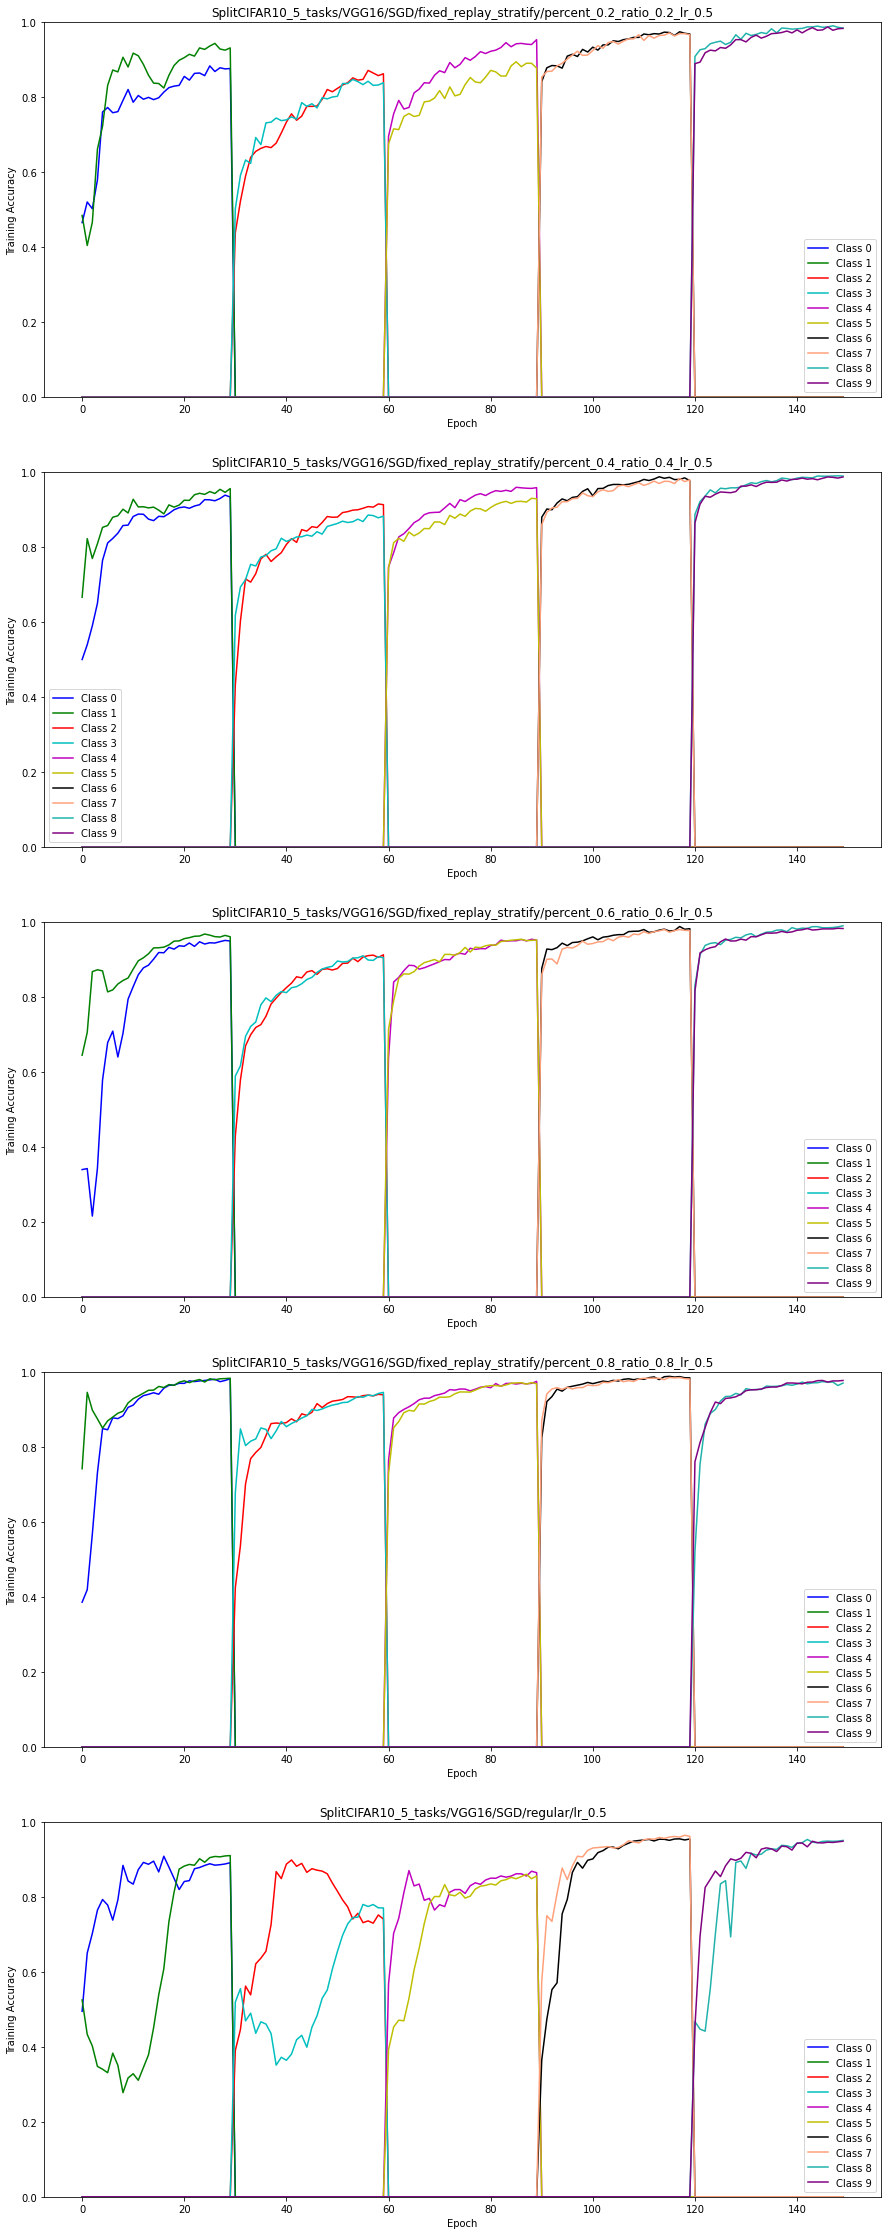

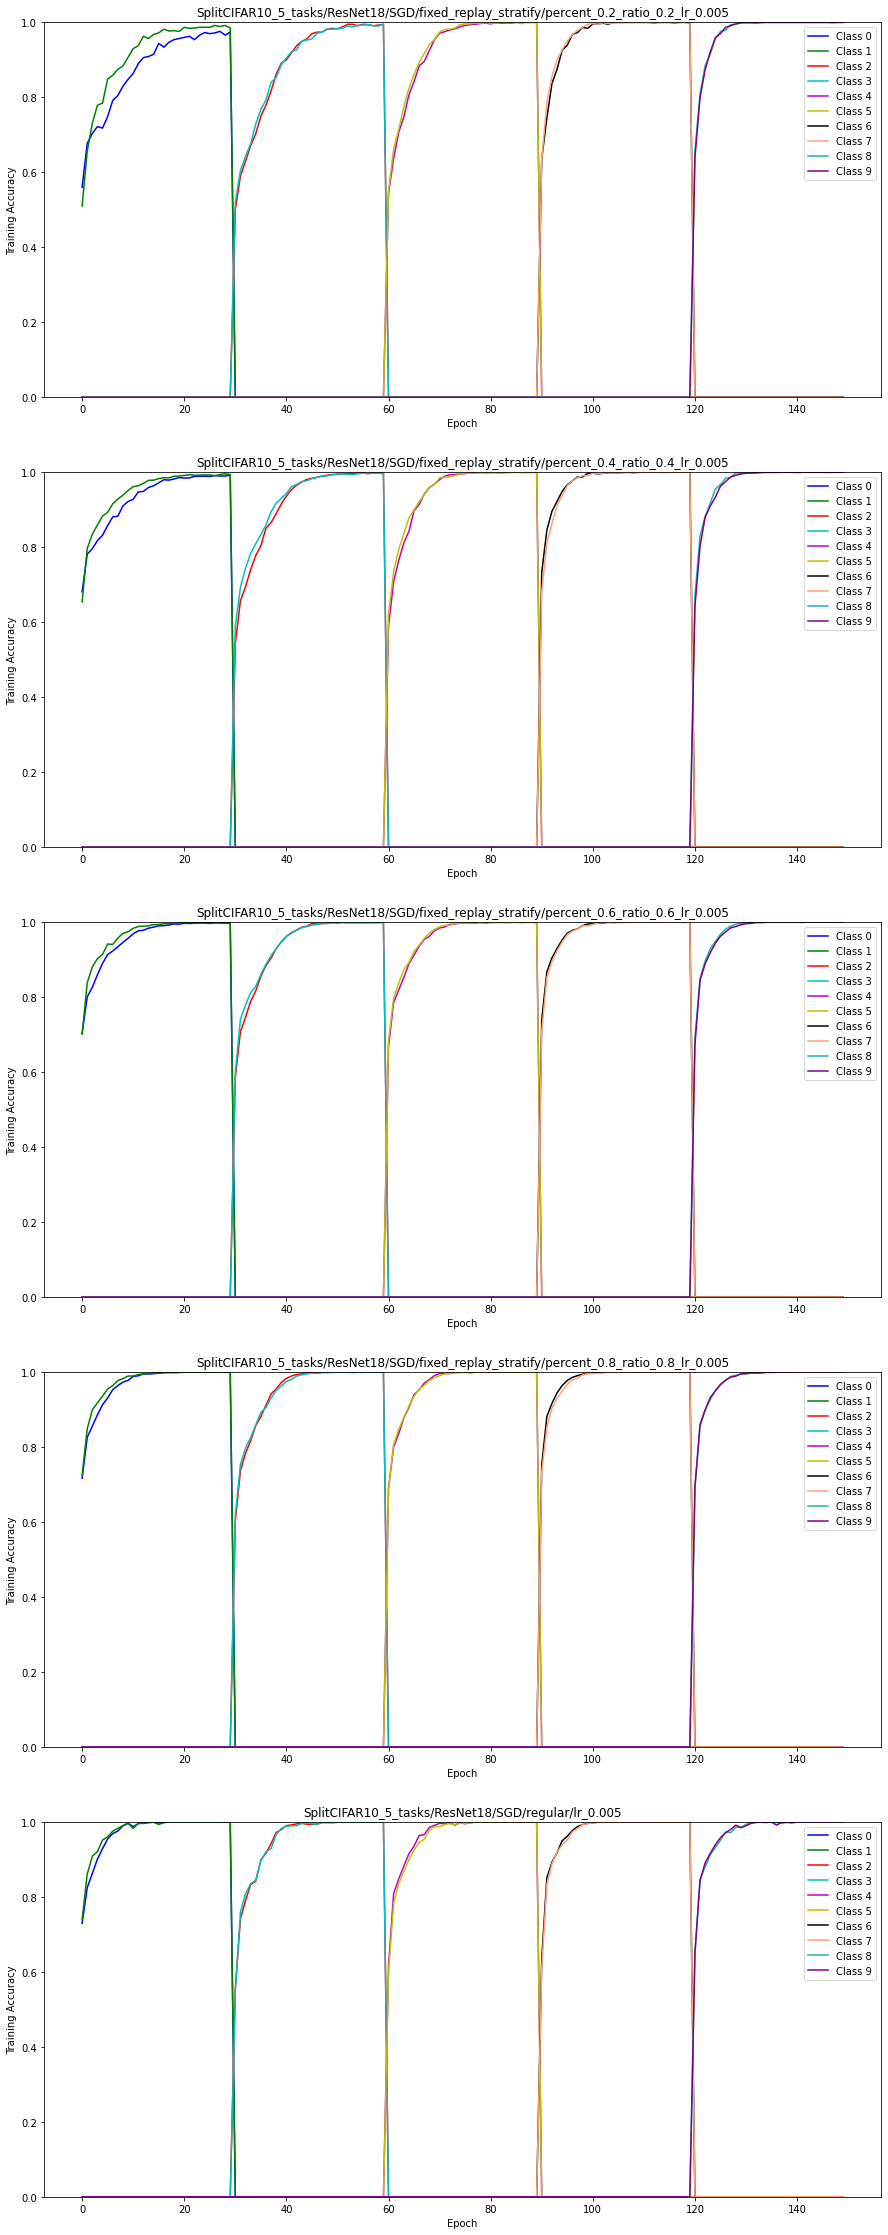

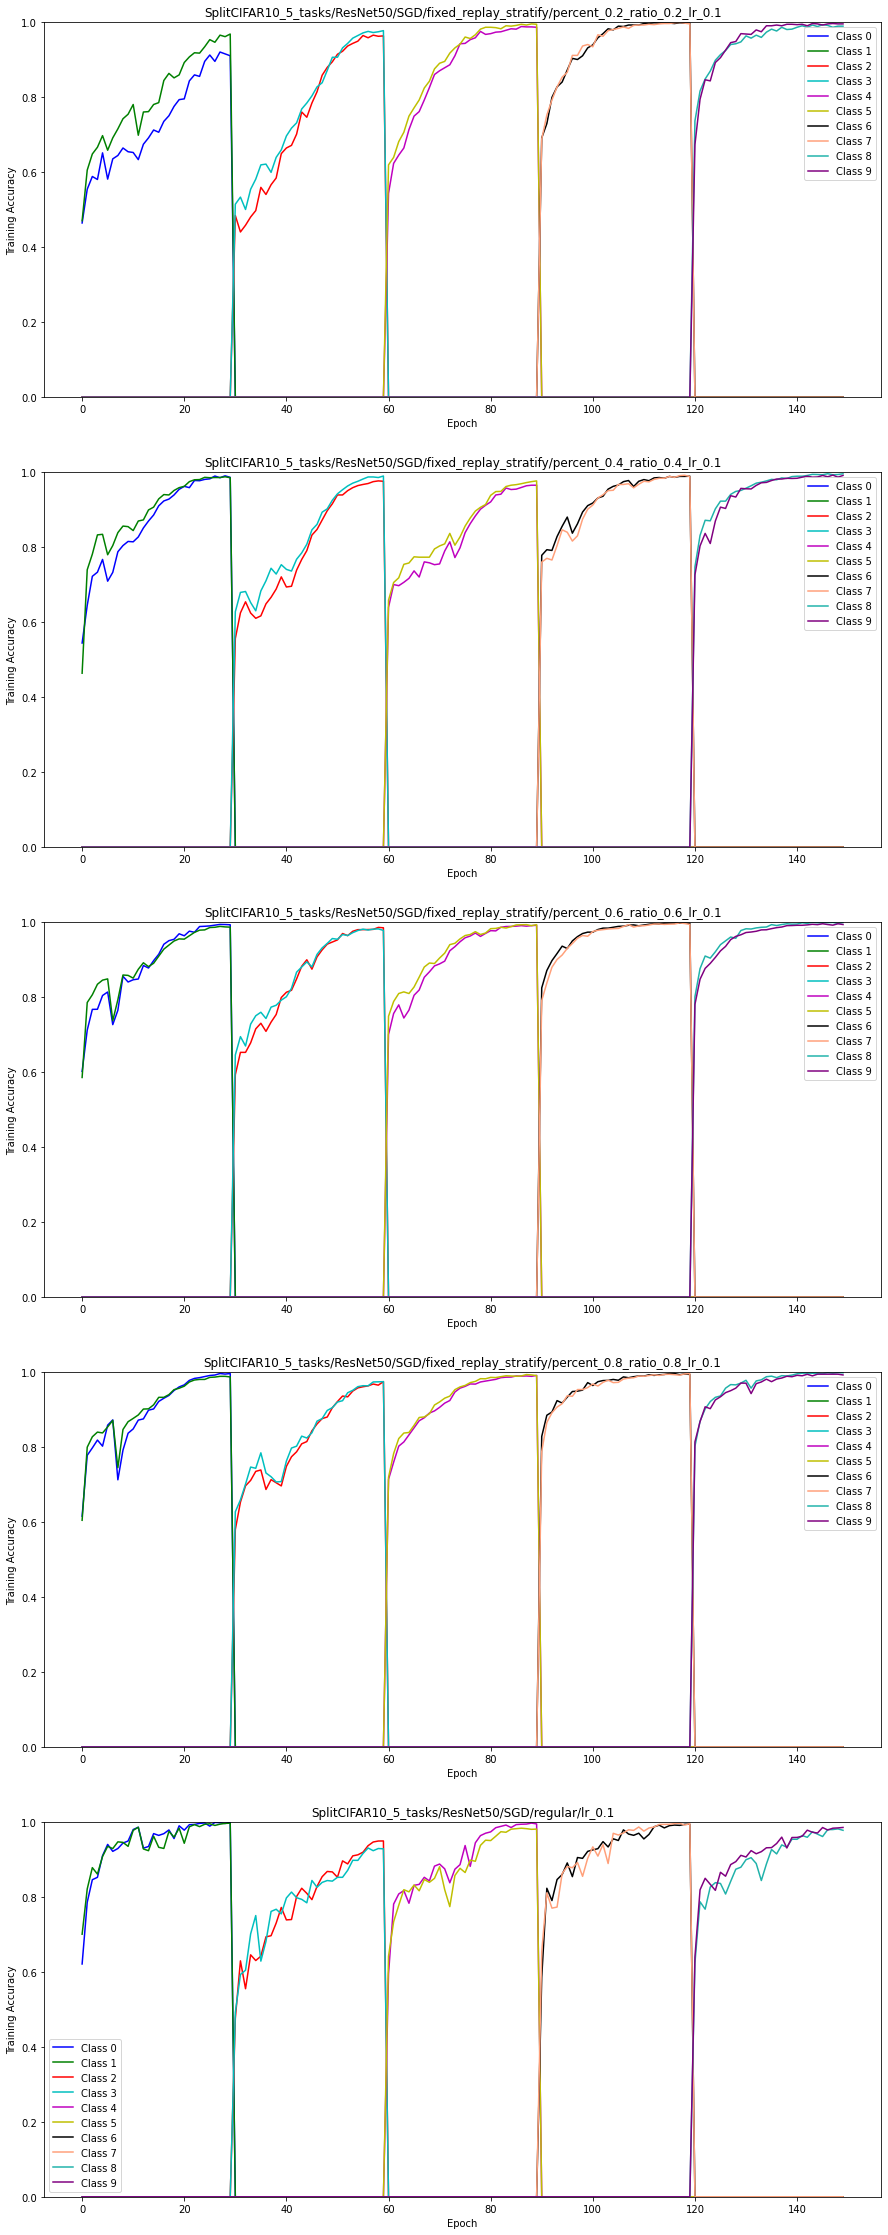

In [23]:
# Let's create a list of all the experiments we want to compare:
ends = [
    "percent_0.2_ratio_0.2_lr_0.5",
    "percent_0.4_ratio_0.4_lr_0.5",
    "percent_0.6_ratio_0.6_lr_0.5",
    "percent_0.8_ratio_0.8_lr_0.5"
]
base_str = "log/SplitCIFAR10_5_tasks/VGG16/SGD/fixed_replay_stratify/"
experiments = [base_str + exp for exp in ends]
experiments.append("log/SplitCIFAR10_5_tasks/VGG16/SGD/regular/lr_0.5")

ends = [
    "percent_0.2_ratio_0.2_lr_0.005",
    "percent_0.4_ratio_0.4_lr_0.005",
    "percent_0.6_ratio_0.6_lr_0.005",
    "percent_0.8_ratio_0.8_lr_0.005"
]

base_str = "log/SplitCIFAR10_5_tasks/ResNet18/SGD/fixed_replay_stratify/"
experiments = experiments + [base_str + exp for exp in ends]
experiments.append("log/SplitCIFAR10_5_tasks/ResNet18/SGD/regular/lr_0.005")

ends = [
    "percent_0.2_ratio_0.2_lr_0.1",
    "percent_0.4_ratio_0.4_lr_0.1",
    "percent_0.6_ratio_0.6_lr_0.1",
    "percent_0.8_ratio_0.8_lr_0.1"
]

base_str = "log/SplitCIFAR10_5_tasks/ResNet50/SGD/fixed_replay_stratify/"
experiments = experiments + [base_str + exp for exp in ends]
experiments.append("log/SplitCIFAR10_5_tasks/ResNet50/SGD/regular/lr_0.1")

# Let's first get the data from our tensorboard logs:
data = []
for exp in experiments:
    data.append(parse_tensorboard(exp, [
        "Top1_Acc_MB/train_phase/train_stream/Task000", 
        "Loss_MB/train_phase/train_stream/Task000",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/3",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/4",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/5",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/6",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/7",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/8",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/9"
    ]))

# Let's now plot a graph for the accuracy and loss over training for each experiment:
for i, exp in enumerate(experiments):
    j = i%5
    if(j == 0):
        fig, ax = plt.subplots(5, 1, figsize=(15, 40))
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0"]["value"], label="Class 0", color=cols[0])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1"]["value"], label="Class 1", color=cols[1])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/2"]["value"], label="Class 2", color=cols[2])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/3"]["value"], label="Class 3", color=cols[3])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/4"]["value"], label="Class 4", color=cols[4])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/5"]["value"], label="Class 5", color=cols[5])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/6"]["value"], label="Class 6", color=cols[6])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/7"]["value"], label="Class 7", color=cols[7])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/8"]["value"], label="Class 8", color=cols[8])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/9"]["value"], label="Class 9", color=cols[9])
    ax[j].set_title(exp[4:])
    ax[j].set_xlabel("Epoch")
    ax[j].set_ylabel("Training Accuracy")
    ax[j].set_ylim([0,1])
    ax[j].legend()


Let's now look at the accuracies achieved during training on the data from the buffer:

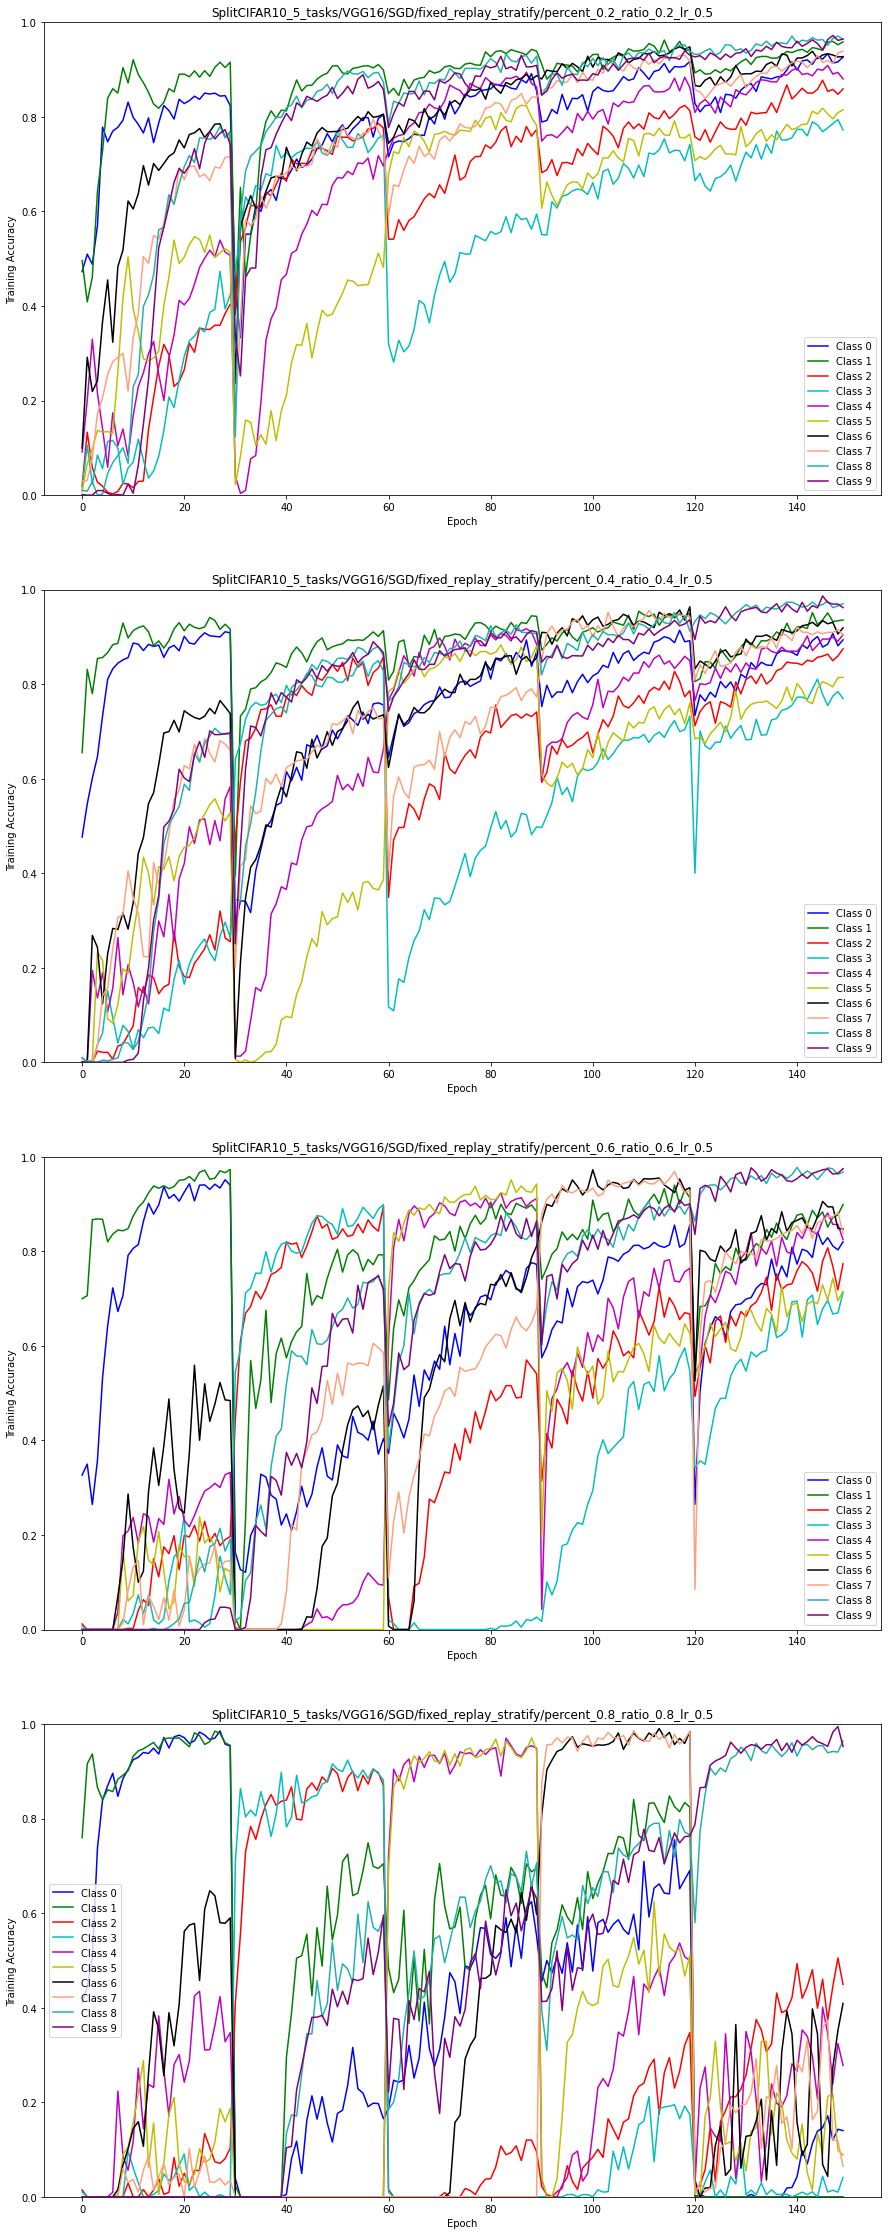

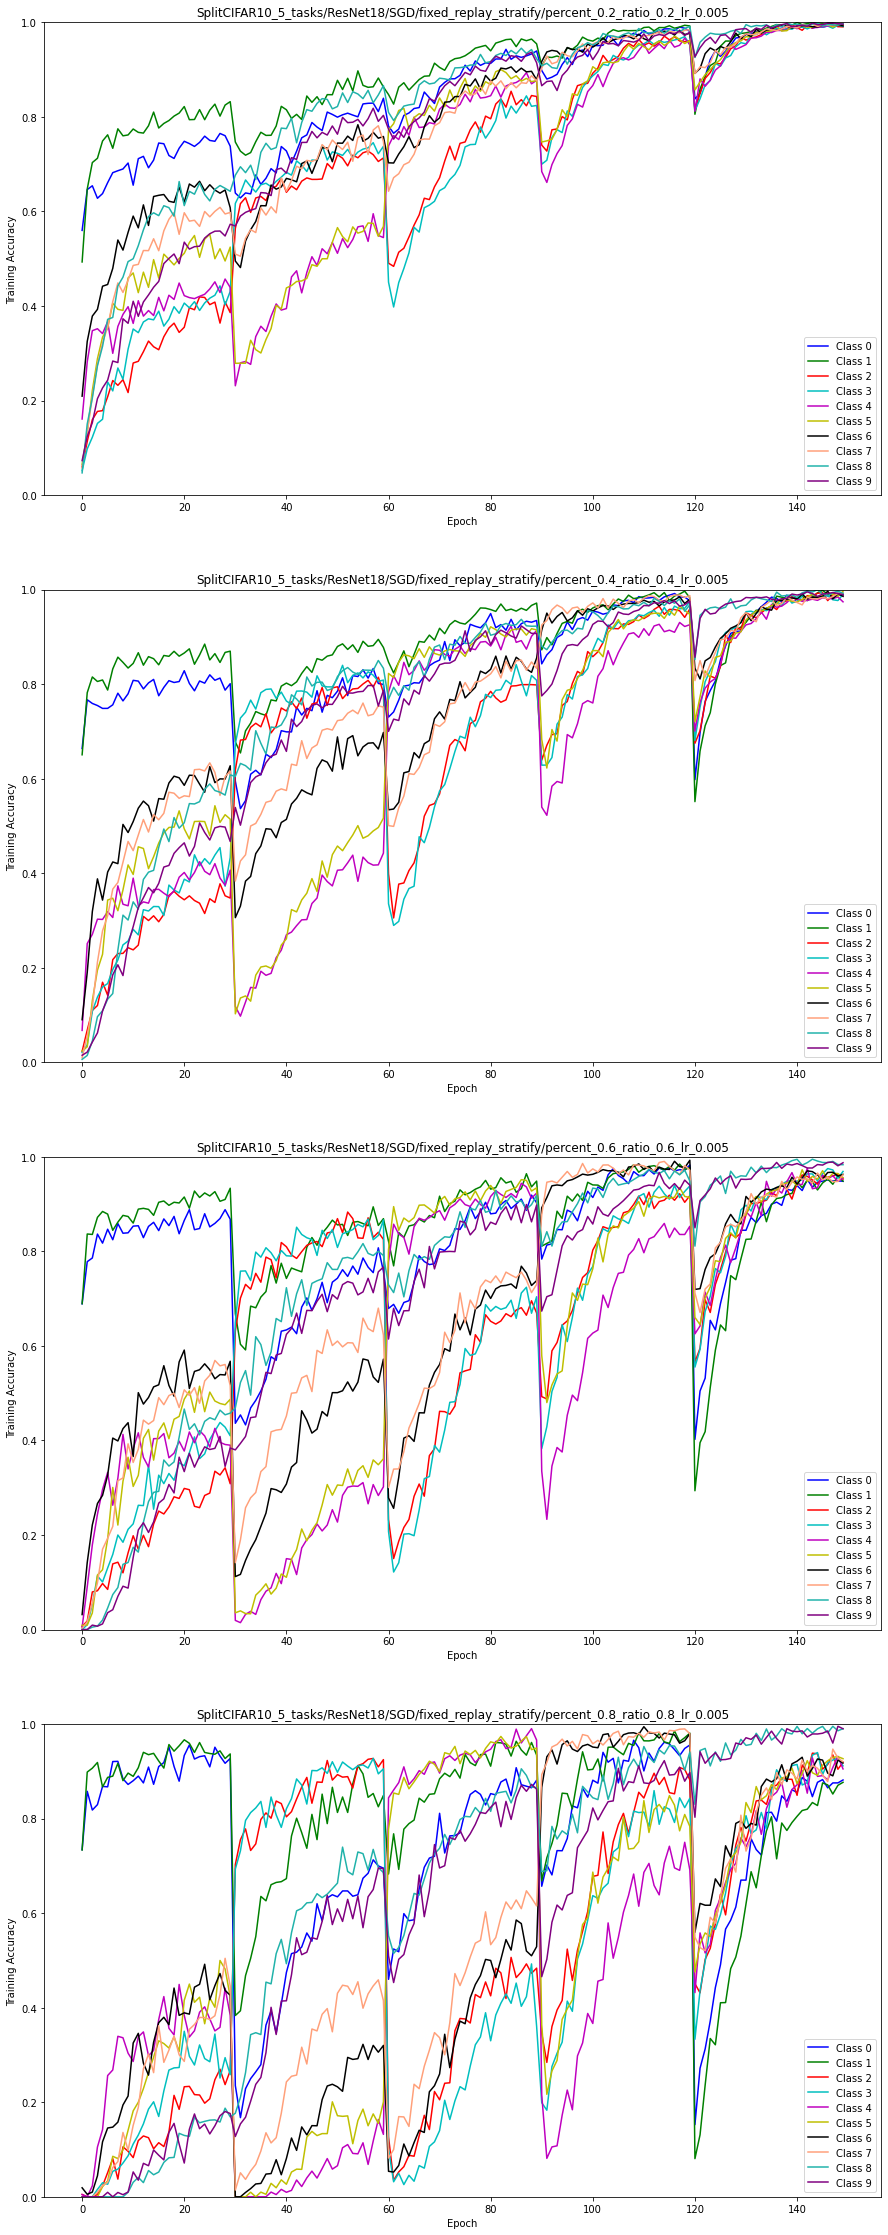

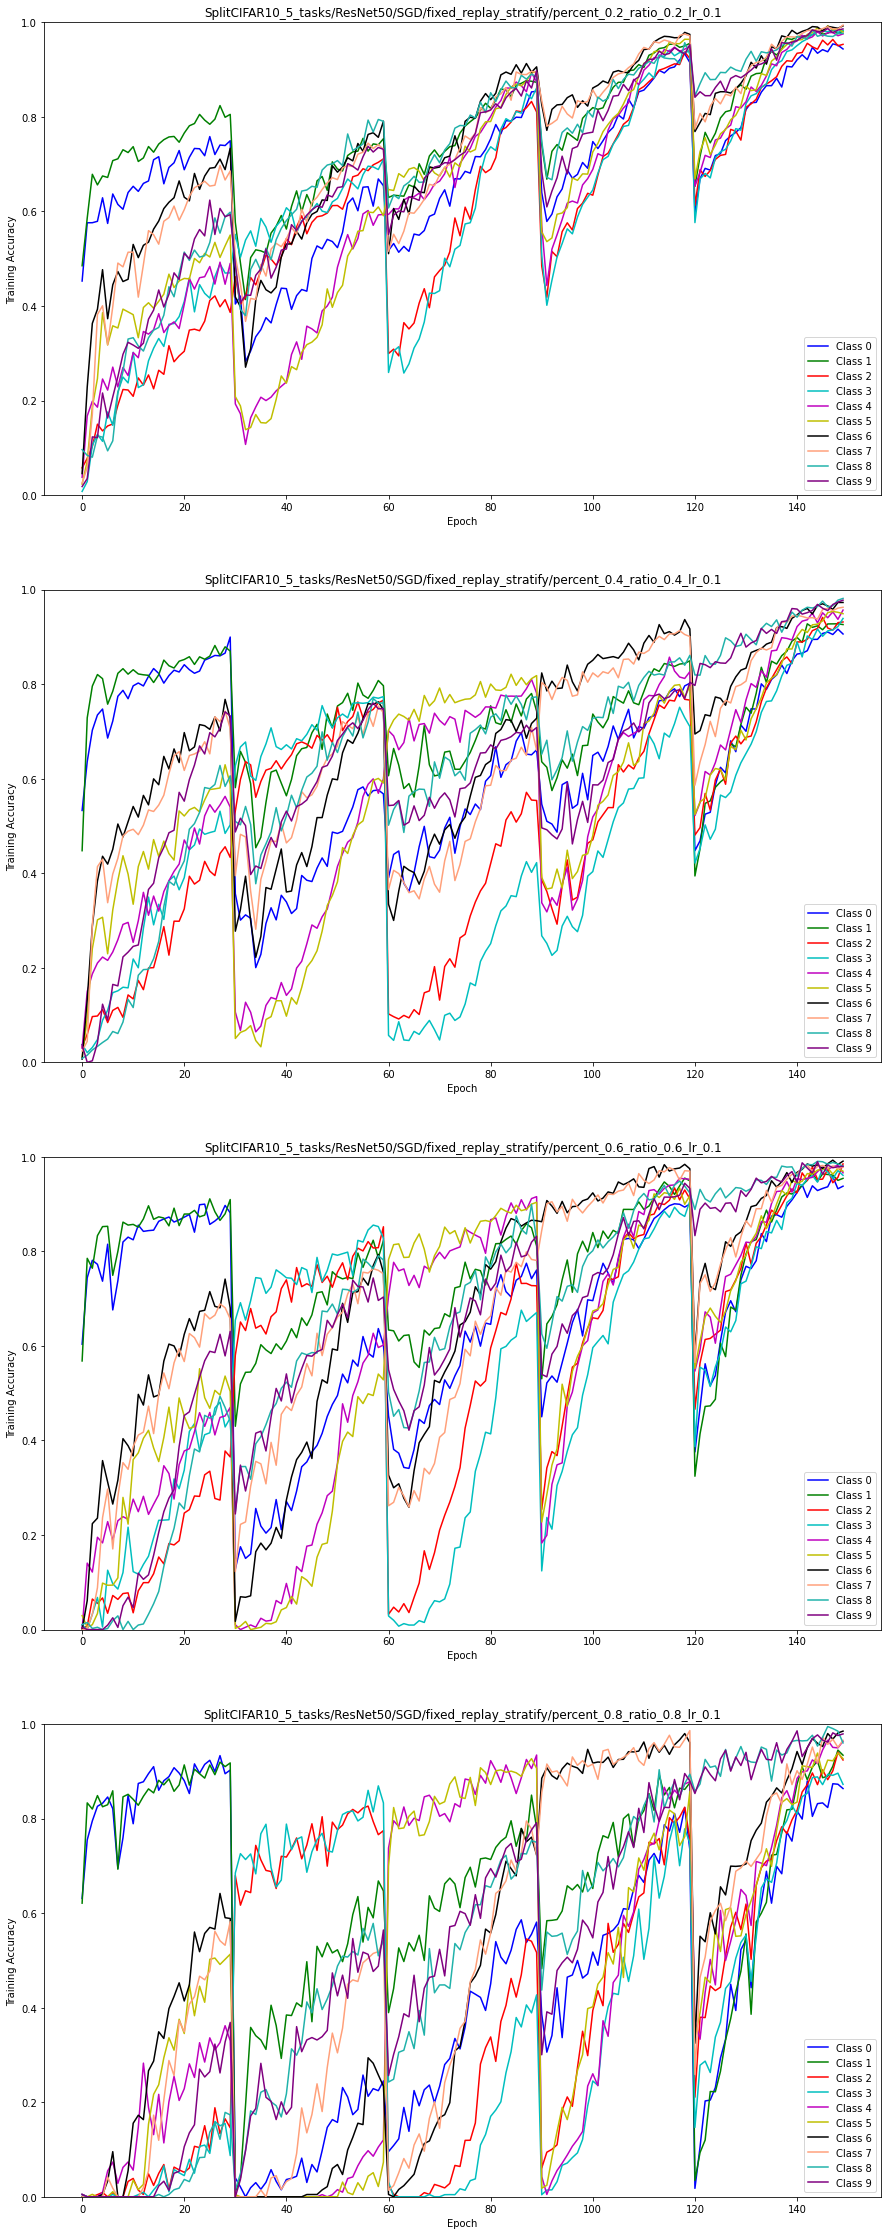

In [24]:
# Let's create a list of all the experiments we want to compare:
ends = [
    "percent_0.2_ratio_0.2_lr_0.5",
    "percent_0.4_ratio_0.4_lr_0.5",
    "percent_0.6_ratio_0.6_lr_0.5",
    "percent_0.8_ratio_0.8_lr_0.5"
]
base_str = "log/SplitCIFAR10_5_tasks/VGG16/SGD/fixed_replay_stratify/"
experiments = [base_str + exp for exp in ends]

ends = [
    "percent_0.2_ratio_0.2_lr_0.005",
    "percent_0.4_ratio_0.4_lr_0.005",
    "percent_0.6_ratio_0.6_lr_0.005",
    "percent_0.8_ratio_0.8_lr_0.005"
]

base_str = "log/SplitCIFAR10_5_tasks/ResNet18/SGD/fixed_replay_stratify/"
experiments = experiments + [base_str + exp for exp in ends]

ends = [
    "percent_0.2_ratio_0.2_lr_0.1",
    "percent_0.4_ratio_0.4_lr_0.1",
    "percent_0.6_ratio_0.6_lr_0.1",
    "percent_0.8_ratio_0.8_lr_0.1"
]

base_str = "log/SplitCIFAR10_5_tasks/ResNet50/SGD/fixed_replay_stratify/"
experiments = experiments + [base_str + exp for exp in ends]

# Let's first get the data from our tensorboard logs:
data = []
for exp in experiments:
    data.append(parse_tensorboard(exp, [
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/0",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/1",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/2",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/3",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/4",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/5",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/6",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/7",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/8",
        "Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/9"
    ]))

# Let's now plot a graph for the accuracy and loss over training for each experiment:
for i, exp in enumerate(experiments):
    j = i%4
    if(j == 0):
        fig, ax = plt.subplots(4, 1, figsize=(15, 40))
    
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/0"]["value"], label="Class 0", color=cols[0])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/1"]["value"], label="Class 1", color=cols[1])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/2"]["value"], label="Class 2", color=cols[2])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/3"]["value"], label="Class 3", color=cols[3])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/4"]["value"], label="Class 4", color=cols[4])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/5"]["value"], label="Class 5", color=cols[5])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/6"]["value"], label="Class 6", color=cols[6])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/7"]["value"], label="Class 7", color=cols[7])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/8"]["value"], label="Class 8", color=cols[8])
    ax[j].plot(data[i]["Top1_ClassAcc_Epoch/train_phase/train_stream/Task002/9"]["value"], label="Class 9", color=cols[9])
    ax[j].set_title(exp[4:])
    ax[j].set_xlabel("Epoch")
    ax[j].set_ylabel("Training Accuracy")
    ax[j].set_ylim([0,1])
    ax[j].legend()

Let's now look at the accuracies achieved after each experience (ie. after training on each task) on the testing data:

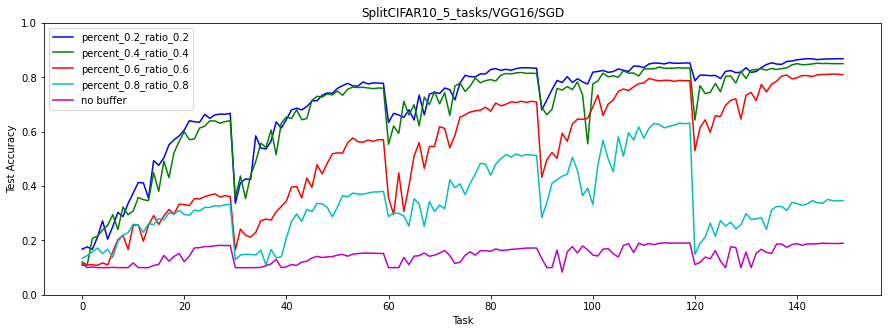

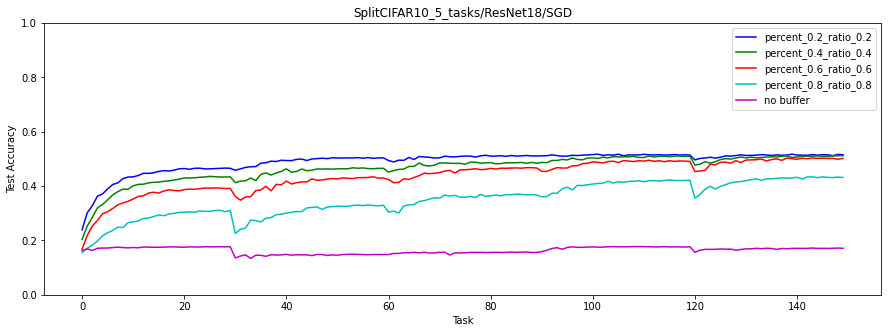

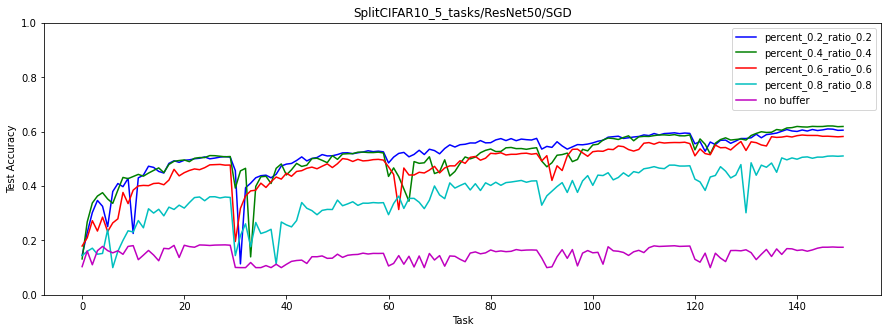

In [25]:
ends = [
    "percent_0.2_ratio_0.2_lr_0.5",
    "percent_0.4_ratio_0.4_lr_0.5",
    "percent_0.6_ratio_0.6_lr_0.5",
    "percent_0.8_ratio_0.8_lr_0.5"
]
base_str = "log/SplitCIFAR10_5_tasks/VGG16/SGD/fixed_replay_stratify/"
experiments = [base_str + exp for exp in ends]
experiments.append("log/SplitCIFAR10_5_tasks/VGG16/SGD/regular/lr_0.5")

ends = [
    "percent_0.2_ratio_0.2_lr_0.005",
    "percent_0.4_ratio_0.4_lr_0.005",
    "percent_0.6_ratio_0.6_lr_0.005",
    "percent_0.8_ratio_0.8_lr_0.005"
]

base_str = "log/SplitCIFAR10_5_tasks/ResNet18/SGD/fixed_replay_stratify/"
experiments = experiments + [base_str + exp for exp in ends]
experiments.append("log/SplitCIFAR10_5_tasks/ResNet18/SGD/regular/lr_0.005")

ends = [
    "percent_0.2_ratio_0.2_lr_0.1",
    "percent_0.4_ratio_0.4_lr_0.1",
    "percent_0.6_ratio_0.6_lr_0.1",
    "percent_0.8_ratio_0.8_lr_0.1"
]

base_str = "log/SplitCIFAR10_5_tasks/ResNet50/SGD/fixed_replay_stratify/"
experiments = experiments + [base_str + exp for exp in ends]
experiments.append("log/SplitCIFAR10_5_tasks/ResNet50/SGD/regular/lr_0.1")

# Let's first get the data from our tensorboard logs:
data = []
for exp in experiments:
    data.append(parse_tensorboard(exp, [
        "Top1_Acc_Stream/eval_phase/test_stream/Task000"
    ]))

# Let's now plot a graph for the accuracy and loss over training for each experiment:
for i, exp in enumerate(experiments):
    j = i%5
    if(j == 0):
        fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    if(j != 4):
        ax.plot(data[i]["Top1_Acc_Stream/eval_phase/test_stream/Task000"]["value"], label=remove_substring_and_after(split_string_by_slash(exp)[-1], "_lr"), color=cols[j])
    else:
        ax.plot(data[i]["Top1_Acc_Stream/eval_phase/test_stream/Task000"]["value"], label="no buffer", color=cols[j])
        ax.set_title(join_strings_with_slash(split_string_by_slash(exp)[1:-2]))
        ax.set_xlabel("Task")
        ax.set_ylabel("Test Accuracy")
        ax.set_ylim([0,1])
        ax.legend()
        plt.show()

Let's now look at the test accuracy again but this time for each individual class:

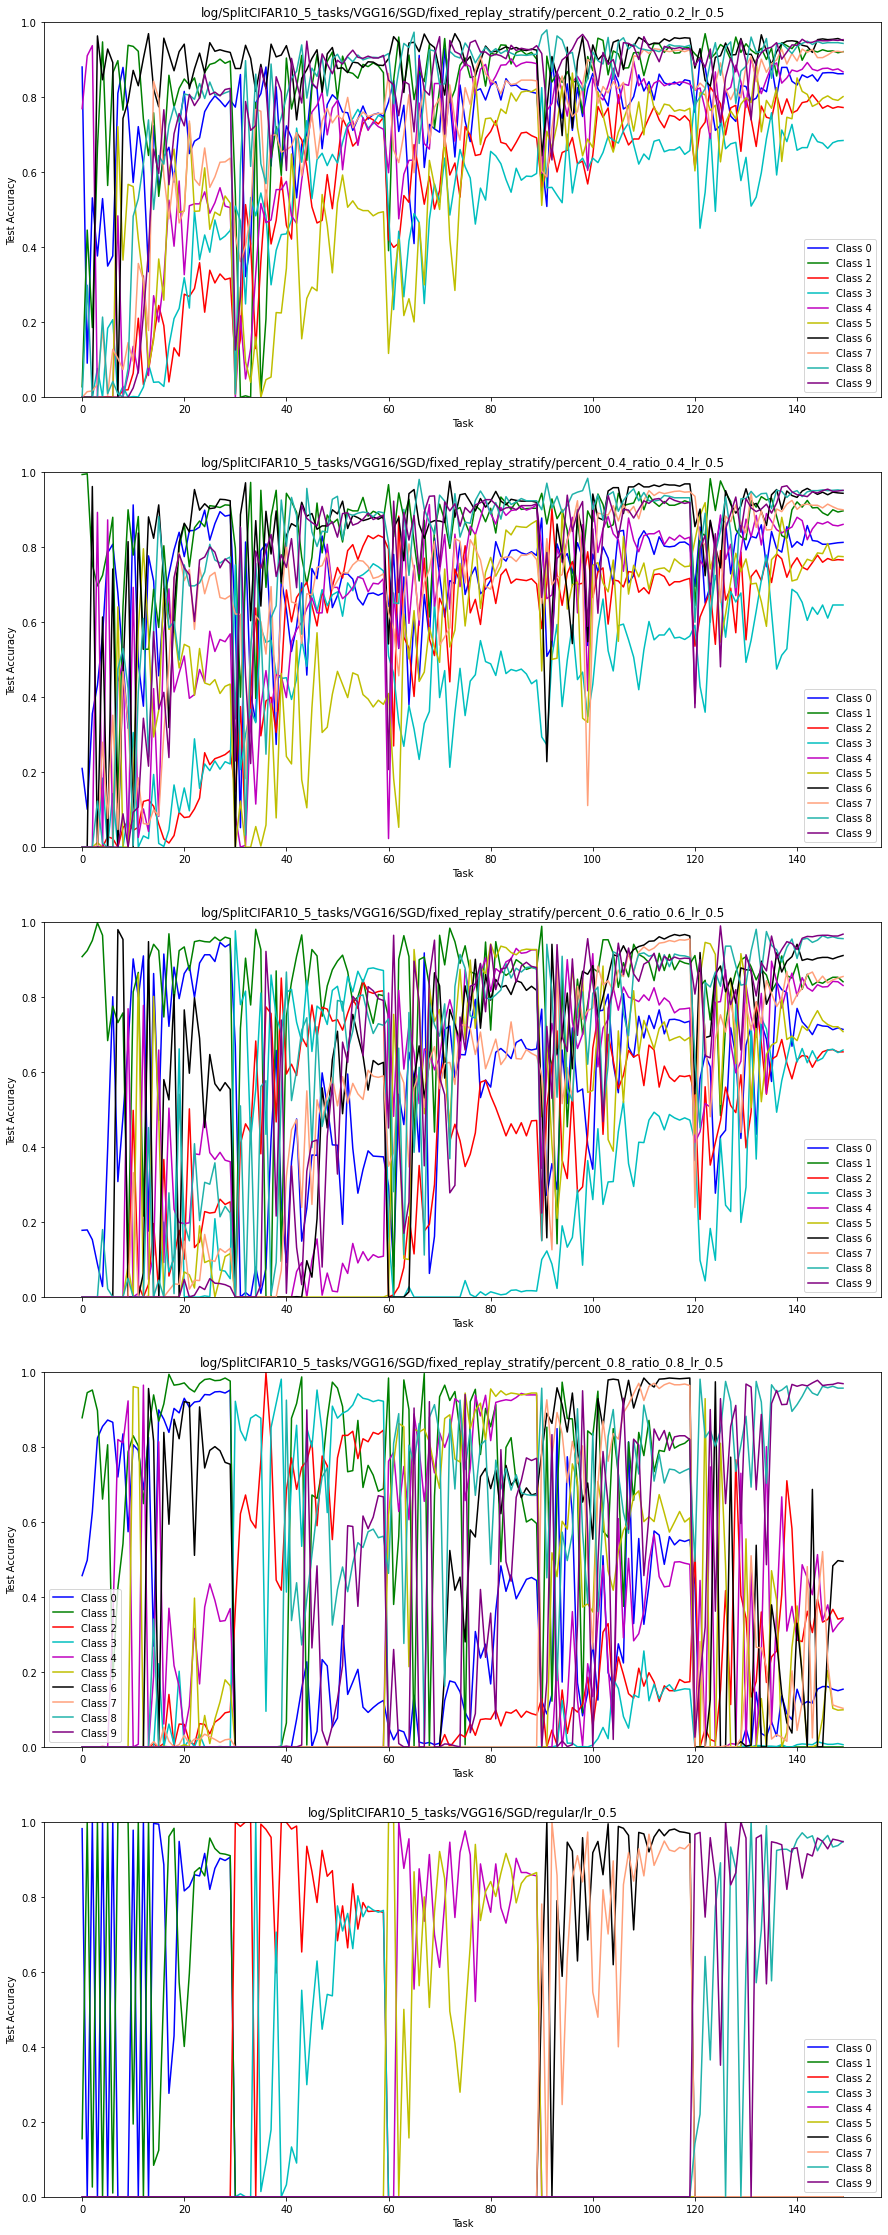

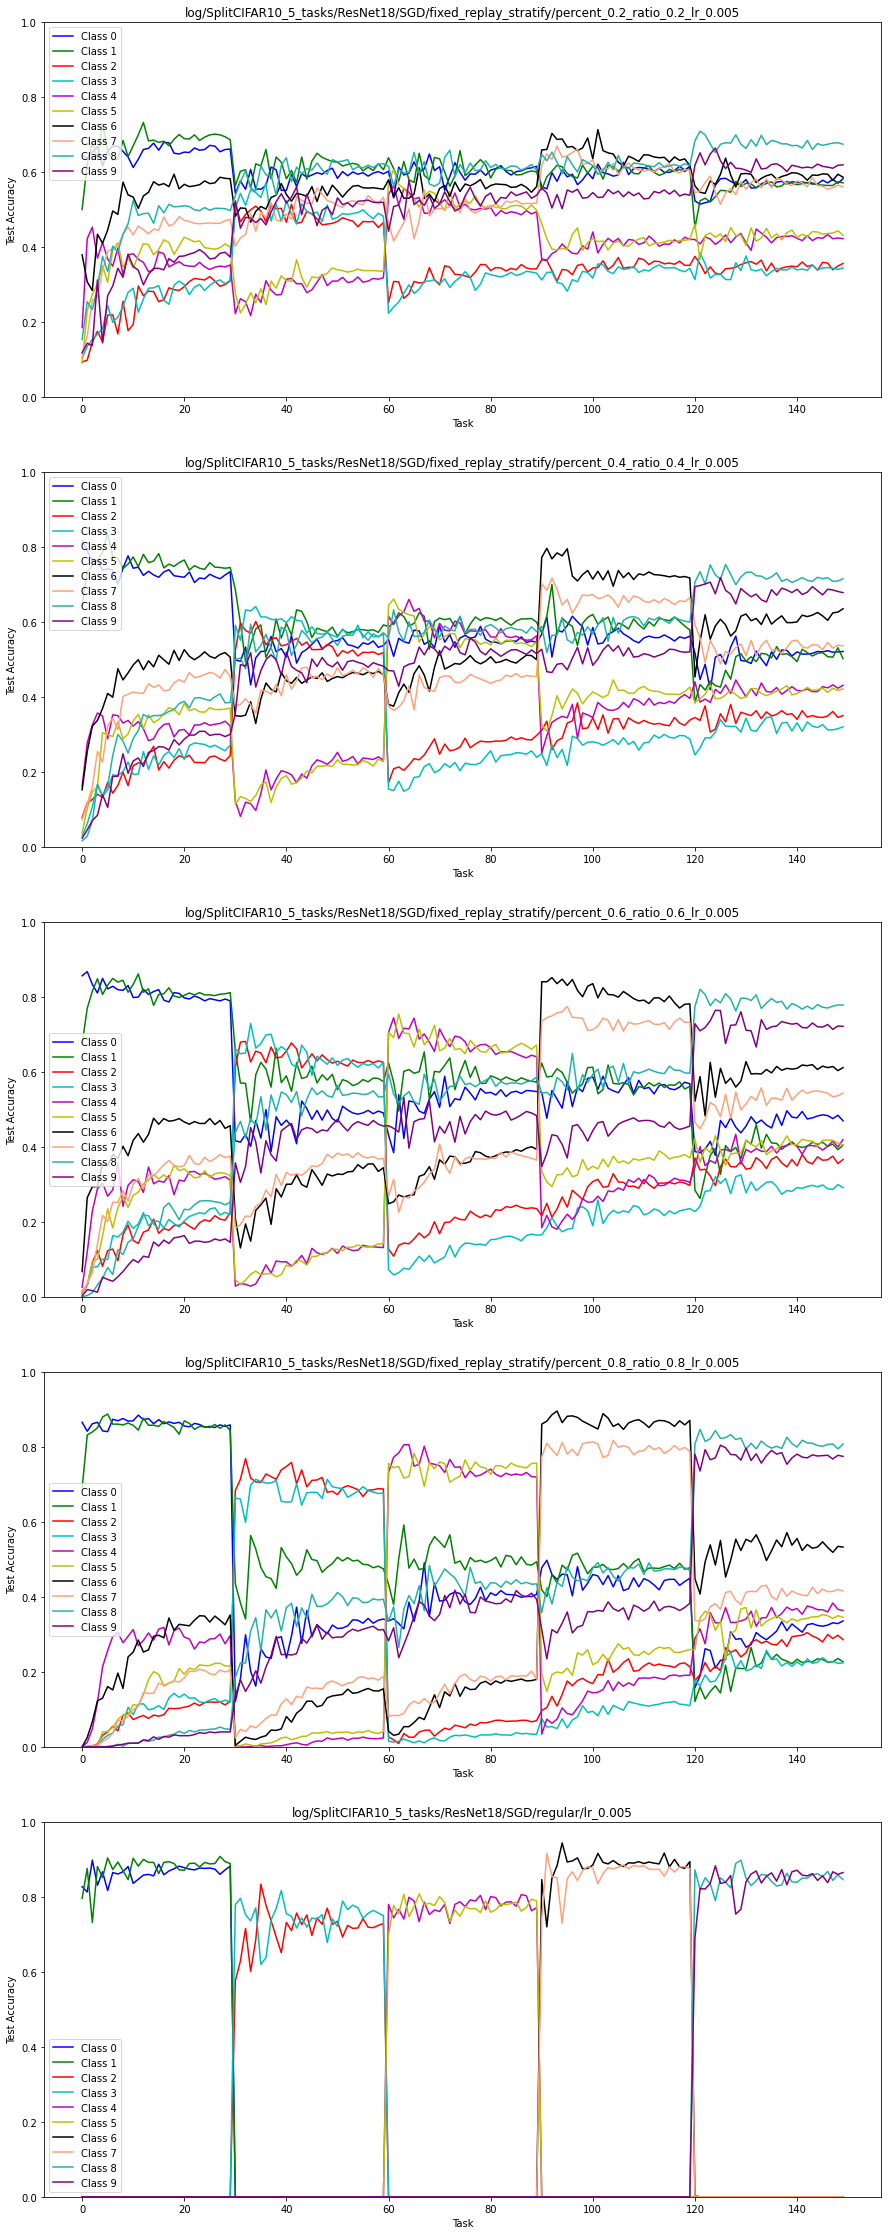

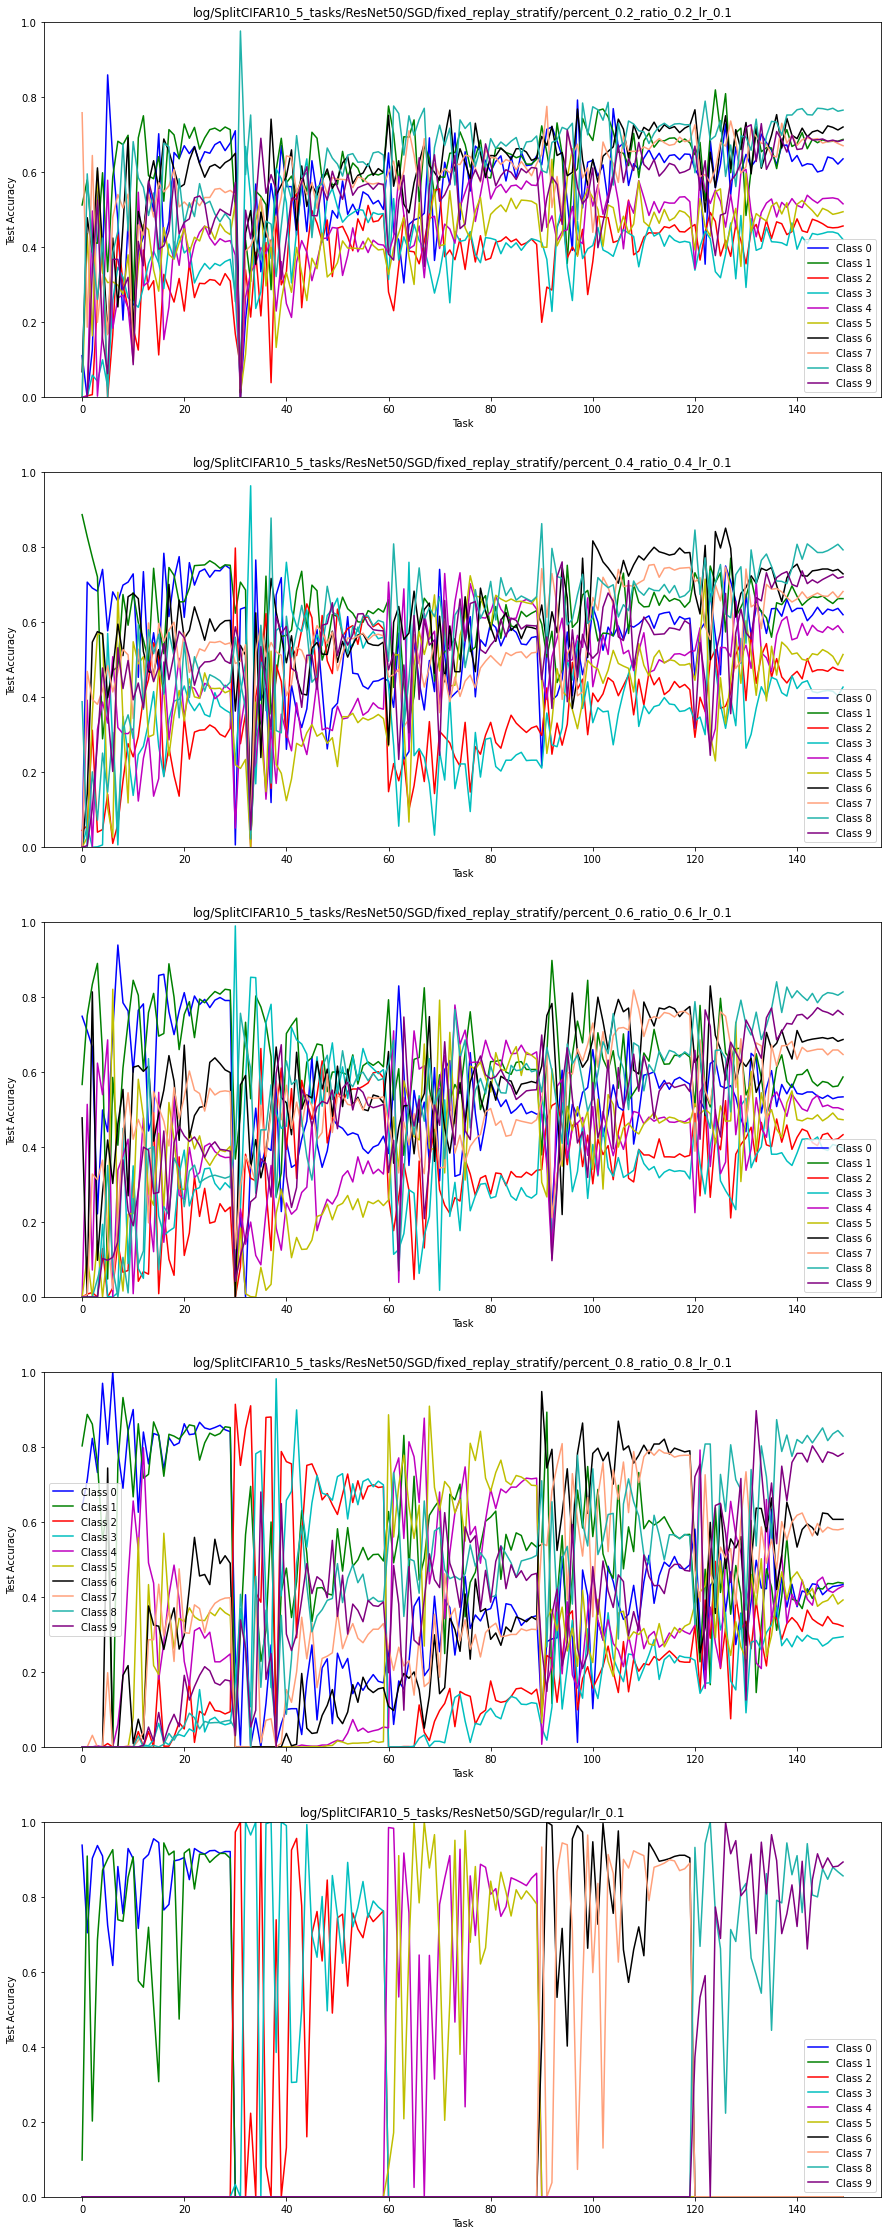

In [26]:
# Let's create a list of all the experiments we want to compare:
ends = [
    "percent_0.2_ratio_0.2_lr_0.5",
    "percent_0.4_ratio_0.4_lr_0.5",
    "percent_0.6_ratio_0.6_lr_0.5",
    "percent_0.8_ratio_0.8_lr_0.5"
]
base_str = "log/SplitCIFAR10_5_tasks/VGG16/SGD/fixed_replay_stratify/"
experiments = [base_str + exp for exp in ends]
experiments.append("log/SplitCIFAR10_5_tasks/VGG16/SGD/regular/lr_0.5")

ends = [
    "percent_0.2_ratio_0.2_lr_0.005",
    "percent_0.4_ratio_0.4_lr_0.005",
    "percent_0.6_ratio_0.6_lr_0.005",
    "percent_0.8_ratio_0.8_lr_0.005"
]

base_str = "log/SplitCIFAR10_5_tasks/ResNet18/SGD/fixed_replay_stratify/"
experiments = experiments + [base_str + exp for exp in ends]
experiments.append("log/SplitCIFAR10_5_tasks/ResNet18/SGD/regular/lr_0.005")

ends = [
    "percent_0.2_ratio_0.2_lr_0.1",
    "percent_0.4_ratio_0.4_lr_0.1",
    "percent_0.6_ratio_0.6_lr_0.1",
    "percent_0.8_ratio_0.8_lr_0.1"
]

base_str = "log/SplitCIFAR10_5_tasks/ResNet50/SGD/fixed_replay_stratify/"
experiments = experiments + [base_str + exp for exp in ends]
experiments.append("log/SplitCIFAR10_5_tasks/ResNet50/SGD/regular/lr_0.1")

# Let's first get the data from our tensorboard logs:
data = []
for exp in experiments:
    data.append(parse_tensorboard(exp, [
        "Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0",
        "Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1",
        "Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/2",
        "Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/3",
        "Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/4",
        "Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/5",
        "Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/6",
        "Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/7",
        "Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/8",
        "Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/9"
    ]))

# Let's now plot a graph for the accuracy and loss over training for each experiment:
for i, exp in enumerate(experiments):
    j = i%5
    if(j == 0):
        plt.show()
        fig, ax = plt.subplots(5, 1, figsize=(15, 40))

    ax[j].plot(data[i]["Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0"]["value"], label="Class 0", color=cols[0])
    ax[j].plot(data[i]["Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1"]["value"], label="Class 1", color=cols[1])
    ax[j].plot(data[i]["Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/2"]["value"], label="Class 2", color=cols[2])
    ax[j].plot(data[i]["Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/3"]["value"], label="Class 3", color=cols[3])
    ax[j].plot(data[i]["Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/4"]["value"], label="Class 4", color=cols[4])
    ax[j].plot(data[i]["Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/5"]["value"], label="Class 5", color=cols[5])
    ax[j].plot(data[i]["Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/6"]["value"], label="Class 6", color=cols[6])
    ax[j].plot(data[i]["Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/7"]["value"], label="Class 7", color=cols[7])
    ax[j].plot(data[i]["Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/8"]["value"], label="Class 8", color=cols[8])
    ax[j].plot(data[i]["Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/9"]["value"], label="Class 9", color=cols[9])

    ax[j].set_title(exp)
    ax[j].set_xlabel("Task")
    ax[j].set_ylabel("Test Accuracy")
    ax[j].set_ylim([0,1])
    ax[j].legend()

In [27]:
tags = get_scalar_tags("log/SplitCIFAR10_5_tasks/ResNet18/SGD/fixed_replay_stratify/percent_0.2_ratio_0.2_lr_0.005")
print(tags)
for tag in tags["scalars"]:
    print(tag)

# data = parse_tensorboard("log/SplitCIFAR10_5_tasks/ResNet18/SGD/fixed_replay_stratify/percent_0.2_ratio_0.2_lr_0.005", [
#         "Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1"
# ])
# data = pd.DataFrame(data['Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1'])
# print(data.head(30))
# print(data['Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0'])

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Top1_Acc_MB/train_phase/train_stream/Task000', 'Loss_MB/train_phase/train_stream/Task000', 'Top1_ClassAcc_MB/train_phase/train_stream/Task000/0', 'Top1_ClassAcc_MB/train_phase/train_stream/Task000/1', 'Top1_ClassAcc_MB/train_phase/train_stream/Task000/2', 'Top1_ClassAcc_MB/train_phase/train_stream/Task000/3', 'Top1_ClassAcc_MB/train_phase/train_stream/Task000/4', 'Top1_ClassAcc_MB/train_phase/train_stream/Task000/5', 'Top1_ClassAcc_MB/train_phase/train_stream/Task000/6', 'Top1_ClassAcc_MB/train_phase/train_stream/Task000/7', 'Top1_ClassAcc_MB/train_phase/train_stream/Task000/8', 'Top1_ClassAcc_MB/train_phase/train_stream/Task000/9', 'Top1_ClassAcc_MB/train_phase/train_stream/Task002/0', 'Top1_ClassAcc_MB/train_phase/train_stream/Task002/1', 'Top1_ClassAcc_MB/train_phase/train_stream/Task002/2', 'Top1_ClassAcc_MB/train_phase/train_stream/Task002/3', 'Top1_ClassAcc_MB/train_phase/train_stream/Task002/4', 'Top1_ClassAcc_MB/train_p